# Exam vB, PROBLEM 1
Maximum Points = 14

In this problem you will do rejection sampling from complicated distributions, you will also be using your samples to compute certain integrals, a method known as Monte Carlo integration: (Keep in mind that choosing a good sampling distribution is often key to avoid too much rejection)

---

## 1. [4p]
Fill in the remaining part of the function `problem1_rejection` in order to produce samples from the below density using rejection sampling:

$$f[x] = C x^{0.2} (1 - x)^{1.3}$$

for $0 \le x \le 1$, where $C$ is a value such that $f$ above is a density (i.e. integrates to one).

Hint: you do not need to know the value of $C$ to perform rejection sampling.

---

## 2. [2p]
Produce 100000 samples (use fewer if it takes too long) and put the answer in `problem1_samples` from the above distribution and plot the histogram.

---

## 3. [2p]
Define $X$ as a random variable with the density given in part 1. Denote $Y = \sin(10X)$ and use the above 100000 samples to estimate

$$E[Y]$$

and store the result in `problem1_expectation`.

---

## 4. [2p]
Use Hoeffdings inequality to produce a 95% confidence interval of the expectation above and store the result as a tuple in the variable `problem1_interval`.

---

## 5. [4p]
Can you calculate an approximation of the value of $C$ from part 1 using random samples? Provide a plot of the histogram from part 2 together with the true density as a curve, recall that this requires the value of $C$. Explain what method you used and what answer you got.

---

In [7]:
# All the necessary packages that could be necessary:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from scipy import optimize
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    confusion_matrix,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


---

## 1. [4p]
Fill in the remaining part of the function `problem1_rejection` in order to produce samples from the below density using rejection sampling:

$$f[x] = C x^{0.2} (1 - x)^{1.3}$$

for $0 \le x \le 1$, where $C$ is a value such that $f$ above is a density (i.e. integrates to one).

Hint: you do not need to know the value of $C$ to perform rejection sampling.

---

In [8]:
import numpy as np

# ------------------------------------------------------------
# Part 1: Rejection sampling for
#   f(x) = C * x^0.2 * (1-x)^1.3,   0 <= x <= 1
#
# We do NOT need C (normalizing constant) for rejection sampling,
# because it cancels in the accept/reject ratio.
#
# We choose proposal g(x) = 1 on [0,1]  =>  X ~ Uniform(0,1).
# ------------------------------------------------------------

# --- Step 1: Estimate M safely (avoid underestimating) -------------------------
# In rejection sampling we need M such that:
#   f_tilde(x) <= M * g(x)  for all x in [0,1]
# With g(x)=1, that means M must be >= max_x f_tilde(x).
#
# If we estimate the max numerically, we might miss the true peak,
# so we multiply by a small "safety factor" to ensure M is not too small.

# M = 1 is a valid upper bound since max_x f_tilde(x) / g(x) < 1,
# but it leads to a lower acceptance rate than the optimal (tight) choice.

# M >= max(f_tilde(x) / g(x))

x_vals = np.random.uniform(0, 1, 10000)
f_vals = x_vals**0.2 * (1 - x_vals)**1.3  # unnormalized target f_tilde(x)
M_est = f_vals.max()                      # estimated maximum of f_tilde(x)

safety_factor = 1.05                      # 5% padding to avoid underestimation
M = safety_factor * M_est

print("M_est (raw)       =", M_est)
print("M (with padding)  =", M)

# --- Step 2: Rejection sampler function ---------------------------------------
def problem1_rejection(n_samples=1):
    """
    Generate n_samples from the density proportional to:
        f_tilde(x) = x^0.2 * (1-x)^1.3, for x in [0,1]
    using rejection sampling with proposal Uniform(0,1).

    Returns:
        samples: numpy array of length n_samples
    """

    samples = []
    proposed = 0

    # Keep proposing until we have enough accepted samples
    while len(samples) < n_samples:
        # 1) Propose X ~ g = Uniform(0,1)
        x = np.random.uniform(0.0, 1.0)

        # 2) Draw U ~ Uniform(0,1) for accept/reject decision
        u = np.random.uniform(0.0, 1.0)

        # 3) Compute unnormalized target at x
        f_tilde_x = x**0.2 * (1 - x)**1.3

        # 4) Since g(x)=1, acceptance probability is:
        #       a(x) = f_tilde(x) / (M * g(x)) = f_tilde(x) / M
        #    (This is guaranteed <= 1 if M is a valid upper bound.)
        acceptance_prob = f_tilde_x / M

        # 5) Accept or reject
        if u <= acceptance_prob:
            samples.append(x)

        proposed += 1

    # Return as numpy array (as the assignment expects)
    return np.array(samples)

# --- Step 3: (Optional) check acceptance rate ---------------------------------
# The assignment function should return samples only.
# But we can still estimate acceptance rate externally for reporting/debugging.

n_samples = 10000

# To measure acceptance rate, we replicate the loop here (same logic),
# but count proposals. This keeps the function return format correct.
accepted = 0
proposed = 0
samples = []

while accepted < n_samples:
    x = np.random.uniform(0.0, 1.0)
    u = np.random.uniform(0.0, 1.0)
    f_tilde_x = x**0.2 * (1 - x)**1.3
    if u <= (f_tilde_x / M):
        samples.append(x)
        accepted += 1
    proposed += 1

samples = np.array(samples)
acceptance_rate = accepted / proposed
print("Acceptance rate:", acceptance_rate)

# If you just want to use the required function:
# samples = problem1_rejection(10000)


M_est (raw)       = 0.5548753922612785
M (with padding)  = 0.5826191618743424
Acceptance rate: 0.5504486156217318


# The code above is fine, but this is the actual correct solution to ALWAYS be correct:


## Choice of proposal distribution

The proposal distribution is chosen as

$$
g(x) = \text{Uniform}(0,1).
$$

This implies

$$
g(x) = 1 \quad \text{for } x \in [0,1].
$$

In rejection sampling, we must choose a constant $M$ such that

$$
f(x) \le M g(x) \quad \text{for all } x \in [0,1].
$$

The acceptance probability is then

$$
\alpha(x) = \frac{f(x)}{M g(x)}.
$$

Since $g(x)=1$, this simplifies to

$$
\alpha(x) = \frac{f(x)}{M}.
$$

---

## Why estimating $M$ numerically is not theoretically valid

Estimating $M$ by evaluating $\tilde f(x)$ on a random grid can underestimate the true maximum.  
If

$$
M_{\text{est}} < \sup_{x \in [0,1]} \tilde f(x),
$$

then for some $x$,

$$
\alpha(x) = \frac{\tilde f(x)}{M_{\text{est}}} > 1,
$$

which violates the rejection sampling algorithm.  
Even if this happens with very small probability, the algorithm is no longer guaranteed to be correct.

Multiplying $M_{\text{est}}$ by a factor such as $1.01$ reduces the risk but does not provide a mathematical guarantee.

---

## Exact determination of $M$

The target density is

$$
f(x) = C x^{0.2}(1-x)^{1.3}, \quad 0 \le x \le 1,
$$

where the normalizing constant $C$ is not needed.

Define the unnormalized density

$$
\tilde f(x) = x^{0.2}(1-x)^{1.3}.
$$

Since $g(x)=1$, it is sufficient to choose

$$
M \ge \max_{x \in [0,1]} \tilde f(x).
$$

For a function of the form

$$
\tilde f(x) = x^a(1-x)^b \quad \text{with } a,b>0,
$$

the maximum occurs at

$$
x^* = \frac{a}{a+b}.
$$

In this case,

$$
a = 0.2, \quad b = 1.3,
$$

which gives

$$
x^* = \frac{0.2}{0.2+1.3} = \frac{2}{15} \approx 0.1333.
$$

The exact envelope constant can therefore be chosen as

$$
M = \tilde f(x^*) = \left(\frac{a}{a+b}\right)^a \left(\frac{b}{a+b}\right)^b.
$$

---

## Conclusion (exam perspective)

- Numerically estimating $M$ may work in practice.
- However, it does not guarantee that $f(x) \le M g(x)$ for all $x$.
- Since an exact maximum exists and can be computed analytically, using an estimated $M$ is not theoretically justified.
- On an exam, this approach would typically result in partial credit, not full points.

To obtain full points, $M$ should be chosen using the analytical maximum of $\tilde f(x)$.


In [9]:
import numpy as np

def problem1_rejection(n_samples=1, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    a = 0.2
    b = 1.3

    # Proposal g(x) = 1 on [0,1]
    # Max of f_tilde(x) = x^a (1-x)^b occurs at x* = a/(a+b)
    x_star = a / (a + b)
    M_tilde = (x_star**a) * ((1 - x_star)**b)  # exact max of f_tilde

    samples = []
    while len(samples) < n_samples:
        x = rng.uniform(0.0, 1.0)   # propose from g
        u = rng.uniform(0.0, 1.0)

        f_tilde = (x**a) * ((1 - x)**b)
        alpha = f_tilde / M_tilde   # since g(x)=1

        if u <= alpha:
            samples.append(x)

    return np.array(samples)


---

## 2. [2p]
Produce 100000 samples (use fewer if it takes too long) and put the answer in `problem1_samples` from the above distribution and plot the histogram.

---

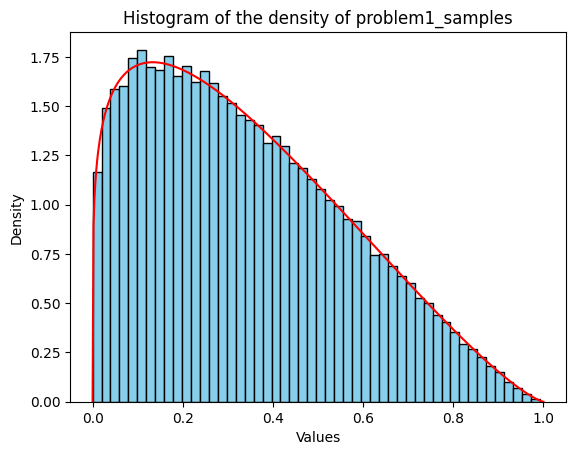

In [10]:
# Part 2
n_samples = 100000
problem1_samples = problem1_rejection(n_samples)

x_vals = np.linspace(0, 1, 500)
f_tilde = x_vals**0.2 * (1 - x_vals)**1.3

f_normalized = f_tilde / np.trapezoid(f_tilde, x_vals)

# Plotting a basic histogram
plt.hist(problem1_samples, bins=50, density=True, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Histogram of the density of problem1_samples')

plt.plot(x_vals, f_normalized, color='r', label='true f_tilde')

# Display the plot
plt.show()

---

## 3. [2p]
Define $X$ as a random variable with the density given in part 1. Denote $Y = \sin(10X)$ and use the above 100000 samples to estimate

$$E[Y]$$

and store the result in `problem1_expectation`.

---


## Estimation of $E[\sin(10X)]$ using Monte Carlo approximation

Let $X$ be a random variable with density $f(x)$ defined in Part 1, supported on the interval $[0,1]$.  
Define the transformed random variable

$Y = \sin(10X)$.

The goal is to estimate the expectation

$E[Y] = E[\sin(10X)]$.

Since this expectation does not admit a simple closed-form expression, we approximate it using a **Monte Carlo method**.

---

### Monte Carlo approximation

If $X_1, X_2, \dots, X_n$ are independent samples drawn from the distribution of $X$, then by the Law of Large Numbers,

$E[\sin(10X)] \approx \frac{1}{n} \sum_{i=1}^{n} \sin(10X_i)$.

As the number of samples $n$ increases, this approximation converges to the true expectation.

---

### Sampling procedure

The samples $X_1, \dots, X_n$ are generated using **rejection sampling**, as constructed in Part 1.  
A uniform proposal distribution $g(x) = \text{Uniform}(0,1)$ is used, ensuring that the accepted samples follow the target density $f(x)$.

---

### Final estimator

Using $n = 100000$ samples, the Monte Carlo estimate is computed as

$E[\sin(10X)] \approx \frac{1}{100000} \sum_{i=1}^{100000} \sin(10X_i)$.

The resulting value is stored in the variable `problem1_expectation`.

---

### Interpretation

This Monte Carlo estimator is unbiased and consistent.  
The approximation error decreases at rate $O(1/\sqrt{n})$, meaning that increasing the number of samples improves the accuracy of the estimate.


In [11]:
# Part 3

# We estimate with:
n_samples = 100000
samples = problem1_rejection(n_samples)
Y = np.sin(10*samples)
E_Y = (1/n_samples) * np.sum(Y)

problem1_expectation = E_Y
print("This is E[Y]: ", problem1_expectation)

This is E[Y]:  0.1892847634943999


---

## 4. [2p]
Use Hoeffdings inequality to produce a 95% confidence interval of the expectation above and store the result as a tuple in the variable `problem1_interval`.

---


In [12]:
# Part 4

# For the Y = sin(10X), Y can be between -1 and 1 maximum and minumum. Therefore the interval we have 
# for Y is [-1, 1].

# smallest value for interval for Y:
a = -1

# Largest value for interval for Y:
b = 1

# alpha for 95% confidence interval:
alpha = 0.05

n_samples = 100000 # Same as above. 

epsilon = (b-a) * np.sqrt((np.log(alpha/2) / (-2*n_samples)))

EY = problem1_expectation

problem1_interval = (EY - epsilon, EY + epsilon)

print("This is the interval we have for Hoeffding inequality: \n", problem1_interval)

This is the interval we have for Hoeffding inequality: 
 (np.float64(0.18069537532746516), np.float64(0.19787415166133465))


---

## 5. [4p]
Can you calculate an approximation of the value of $C$ from part 1 using random samples? Provide a plot of the histogram from part 2 together with the true density as a curve, recall that this requires the value of $C$. Explain what method you used and what answer you got.

-----

In [13]:
# Part 5
n_samples = 100000
x_samples = np.random.uniform(0, 1, n_samples)
f_tilde = x_samples**0.2 * (1-x_samples)**1.3
I = (1 / n_samples) * sum(f_tilde)

C = 1 / I


problem1_C = C
print("Approximation of C is: ", problem1_C)

Approximation of C is:  3.094452915724885


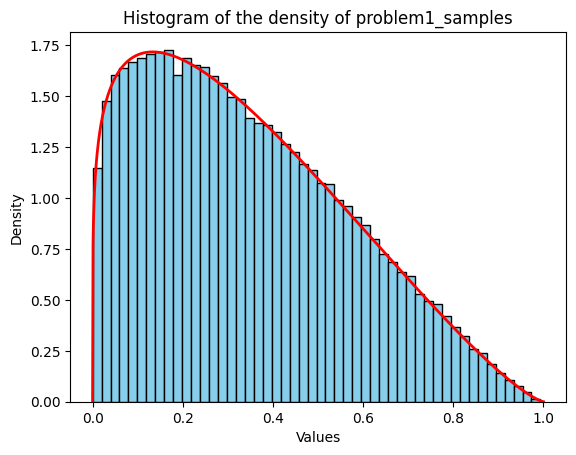

In [14]:
# Part 5
# Write your code to produce the plot here
#XXXXXXX

# Part 2
n_samples = 100000
problem1_samples = problem1_rejection(n_samples)

xs = np.linspace(0, 1, 1000)
f_true = problem1_C * xs**0.2 * (1 - xs)**1.3

#f_normalized = f_true / np.trapezoid(f_true, x_samples)

# Plotting a basic histogram
plt.hist(problem1_samples, bins=50, density=True, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Histogram of the density of problem1_samples')

plt.plot(xs, f_true, color='red', linewidth=2, label='True density')

# Display the plot
plt.show()

In [15]:
# This cell is just to check that you got the correct formats of your answer
import numpy as np

try:
    assert(isinstance(problem1_rejection(10), np.ndarray))
except:
    print("Try again. You should return a numpy array from problem1_rejection")
else:
    print("Good, your problem1_rejection returns a numpy array")

try:
    assert(isinstance(problem1_samples, np.ndarray))
except:
    print("Try again. your problem1_samples is not a numpy array")
else:
    print("Good, your problem1_samples is a numpy array")

try:
    assert(isinstance(problem1_expectation, float))
except:
    print("Try again. your problem1_expectation is not a float")
else:
    print("Good, your problem1_expectation is a float")

try:
    assert(isinstance(problem1_interval, list) or isinstance(problem1_interval, tuple)) , "problem1_interval not a tuple or list"
    assert(len(problem1_interval) == 2) , "problem1_interval does not have length 2, it should have a lower bound and an upper bound"
except Exception as e:
    print(e)
else:
    print("Good, your problem1_interval is a tuple or list of length 2")

try:
    assert(isinstance(problem1_rejection_2(10), np.ndarray))
except:
    print("Try again. You should return a numpy array from problem1_rejection_2")
else:
    print("Good, your problem1_rejection_2 returns a numpy array")

Good, your problem1_rejection returns a numpy array
Good, your problem1_samples is a numpy array
Good, your problem1_expectation is a float
Good, your problem1_interval is a tuple or list of length 2
Try again. You should return a numpy array from problem1_rejection_2


## Exam vB, PROBLEM 2
**Maximum Points = 13**

Let us build a proportional model ($P(Y = 1 | X) = G(\beta_0 + \beta \cdot X)$ where $G$ is the logistic function)
for the spam vs not spam data. Here we assume that the features are presence vs not presence of a
word, let $X_1, X_2, X_3$ denote the presence (1) or absence (0) of the words (“free”, “prize”, “win”).

---

### 1. [2p]
Load the file `data/spam.csv` and create two numpy arrays, `problem2_X` which has
shape $(n_{\text{emails}}, 3)$ where each feature in `problem2_X` corresponds to
$X_1, X_2, X_3$ from above, `problem2_Y` which has shape $(n_{\text{emails}},)$ and
consists of a 1 if the email is spam and 0 if it is not.

Split this data into a train–calibration–test set where we have the split 40%, 20%, 40%.
Put this data in the designated variables in the code cell.

---

### 2. [4p]
Follow the calculation from the lecture notes where we derive the logistic regression
and implement the final loss function inside the class `ProportionalSpam`.
You can use the Test cell to check that it gives the correct value for a test-point.

---

### 3. [4p]
Train the model `problem2_ps` on the training data.  
The goal is to calibrate the probabilities output from the model.

Start by creating a new variable `problem2_X_pred` (shape $(n_{\text{samples}}, 1)$)
which consists of the predictions of `problem2_ps` on the calibration dataset.

Then train a calibration model using `sklearn.tree.DecisionTreeRegressor`,
store this trained model in `problem2_calibrator`.

---

### 4. [3p]
Use the trained model `problem2_ps` and the calibrator `problem2_calibrator` to make
final predictions on the testing data, store the prediction in
`problem2_final_predictions`.

Compute the $0 - 1$ test-loss and store it in `problem2_01_loss` and provide a
99% confidence interval of it.  
Store this interval in the variable `problem2_interval`
(this should again be a tuple as in Problem 1).


-----
## Exam vB, PROBLEM 2
**Maximum Points = 13**

Let us build a proportional model ($P(Y = 1 | X) = G(\beta_0 + \beta \cdot X)$ where $G$ is the logistic function)
for the spam vs not spam data. Here we assume that the features are presence vs not presence of a
word, let $X_1, X_2, X_3$ denote the presence (1) or absence (0) of the words (“free”, “prize”, “win”).

---

### 1. [2p]
Load the file `data/spam.csv` and create two numpy arrays, `problem2_X` which has
shape $(n_{\text{emails}}, 3)$ where each feature in `problem2_X` corresponds to
$X_1, X_2, X_3$ from above, `problem2_Y` which has shape $(n_{\text{emails}},)$ and
consists of a 1 if the email is spam and 0 if it is not.

Split this data into a train–calibration–test set where we have the split 40%, 20%, 40%.
Put this data in the designated variables in the code cell.

-----


In [16]:
# Import numpy for numerical arrays and indexing
import numpy as np

# Import pandas for reading CSV files and handling tabular data
import pandas as pd


# -----------------------------
# 1) Load the spam dataset
# -----------------------------

# Read the CSV file
# - usecols selects only the two columns we need:
#   v1 = label ("ham" or "spam")
#   v2 = email text
# - encoding="latin1" is needed because the file contains special characters
data = pd.read_csv("data/spam.csv", encoding="latin1", usecols=["v1", "v2"])


# -----------------------------
# 2) Define the words (features)
# -----------------------------

# These are the three words we check for in each email
# X1 = presence of "free"
# X2 = presence of "prize"
# X3 = presence of "win"
words = ["free", "prize", "win"]


# -----------------------------
# 3) Extract email texts safely
# -----------------------------

# Select the email text column (v2)
# fillna("") → replace missing values (NaN) with empty strings
# astype(str) → make sure every value is a string
#
# This guarantees that string operations like .str.contains()
# will NOT crash.
texts = data["v2"].fillna("").astype(str)


# -----------------------------
# 4) Create feature matrix X
# -----------------------------

# Create an empty matrix of zeros
# Shape: (number of emails, 3 words)
#
# Each row = one email
# Each column = one word ("free", "prize", "win")
problem2_X = np.zeros((len(data), 3), dtype=int)


# Loop over the words and fill one column at a time
for j, w in enumerate(words):
    # texts.str.contains(w, case=False):
    #   → True if the word w appears in the email (ignoring case)
    #
    # astype(int):
    #   → True → 1, False → 0
    #
    # to_numpy():
    #   → convert from pandas Series to numpy array
    #
    # problem2_X[:, j]:
    #   → fill column j of X with these 0/1 values
    problem2_X[:, j] = (
        texts.str.contains(w, case=False, regex=False)
        .astype(int)
        .to_numpy()
    )


# -----------------------------
# 5) Create label vector Y
# -----------------------------

# data["v1"] contains "spam" or "ham"
# (data["v1"] == "spam") gives True for spam, False otherwise
# astype(int): True → 1, False → 0
problem2_Y = (data["v1"] == "spam").astype(int).to_numpy()


# -----------------------------
# 6) Split into train / calib / test
# -----------------------------

# Total number of emails
n = len(data)

# Randomly shuffle indices 0, 1, ..., n-1
# This ensures a random split
idx = np.random.permutation(n)

# Number of samples in each split
n_train = int(0.40 * n)   # 40% training
n_calib = int(0.20 * n)   # 20% calibration
# Remaining 40% automatically go to test

# Indices for each split
train_idx = idx[:n_train]
calib_idx = idx[n_train : n_train + n_calib]
test_idx  = idx[n_train + n_calib :]


# Use the indices to split X
problem2_X_train = problem2_X[train_idx]
problem2_X_calib = problem2_X[calib_idx]
problem2_X_test  = problem2_X[test_idx]

# Use the same indices to split Y
problem2_Y_train = problem2_Y[train_idx]
problem2_Y_calib = problem2_Y[calib_idx]
problem2_Y_test  = problem2_Y[test_idx]


# -----------------------------
# 7) Verify shapes (VERY IMPORTANT)
# -----------------------------

# This confirms that the split is correct
print(problem2_X_train.shape,
      problem2_X_calib.shape,
      problem2_X_test.shape,
      problem2_Y_train.shape,
      problem2_Y_calib.shape,
      problem2_Y_test.shape)


(2228, 3) (1114, 3) (2230, 3) (2228,) (1114,) (2230,)


In [17]:
# THIS CODE ALSO WORKS AND IS EVEN EASIER TO UNDERSTAND:


import numpy as np
import pandas as pd


# -----------------------------
# 1) Load the data
# -----------------------------

data = pd.read_csv(
    "data/spam.csv",
    encoding="latin1",
    usecols=["v1", "v2"]
)


# -----------------------------
# 2) Prepare the email text
# -----------------------------

# Extract the email text column
# fillna("")  → replace missing values (NaN) with empty strings
# astype(str) → ensure all values are strings
texts = data["v2"].fillna("").astype(str)


# -----------------------------
# 3) Create feature columns
# -----------------------------

# texts.str.contains("free", case=False, regex=False)
#
# case=False:
#   - Ignore letter case
#   - "FREE", "Free", "free" all count as matches
#
# regex=False:
#   - Treat "free" as a literal word, not a regular expression
#   - Prevents special regex characters from being interpreted
#
# astype(int):
#   - True  → 1 (word is present)
#   - False → 0 (word is not present)
#
# to_numpy():
#   - Convert pandas Series to numpy array
x_free = (texts.str.contains("free", case=False, regex=False).astype(int).to_numpy())


# Same logic for the word "prize"
x_prize = (texts.str.contains("prize", case=False, regex=False).astype(int).to_numpy())


# Same logic for the word "win"
x_win = (texts.str.contains("win", case=False, regex=False).astype(int).to_numpy())


# -----------------------------
# 4) Combine feature columns
# -----------------------------

# Combine the three feature vectors into a matrix
# Each row corresponds to one email:
#   [contains_free, contains_prize, contains_win]
problem2_X = np.array([x_free, x_prize, x_win]).T
print(problem2_X)


# -----------------------------
# 5) Create label vector
# -----------------------------

# Convert labels to numeric values
# "spam" → 1
# "ham"  → 0
problem2_Y = ((data["v1"] == "spam").astype(int).to_numpy())


# -----------------------------
# 6) Split into train / calib / test
# -----------------------------

# 40% / 20% / 40% split (sequential, same style as your other exercise)
n = problem2_X.shape[0]
n_train = int(0.4 * n)
n_calib = int(0.2 * n)

# Training points from 0 to n_train -1
problem2_X_train = problem2_X[:n_train]
# Start from n_train to n_train + n_calib -1
problem2_X_calib = problem2_X[n_train:n_train + n_calib]
# From n_train + n_calib to end
problem2_X_test  = problem2_X[n_train + n_calib:]

problem2_Y_train = problem2_Y[:n_train]
problem2_Y_calib = problem2_Y[n_train:n_train + n_calib]
problem2_Y_test  = problem2_Y[n_train + n_calib:]


# -----------------------------
# 7) Verify shapes
# -----------------------------

print(problem2_X_train.shape,
      problem2_X_calib.shape,
      problem2_X_test.shape,
      problem2_Y_train.shape,
      problem2_Y_calib.shape,
      problem2_Y_test.shape)


[[0 0 0]
 [0 0 0]
 [1 0 1]
 ...
 [0 0 0]
 [1 0 0]
 [0 0 0]]
(2228, 3) (1114, 3) (2230, 3) (2228,) (1114,) (2230,)


---

### 2. [4p]
Follow the calculation from the lecture notes where we derive the logistic regression
and implement the final loss function inside the class `ProportionalSpam`.
You can use the Test cell to check that it gives the correct value for a test-point.

---



In [18]:
# Part 2
class ProportionalSpam(object):
    def __init__(self):
        self.coeffs = None
        self.result = None

    # define the objective/cost/loss function we want to minimise
    def loss(self, X, Y, coeffs):
        b0 = coeffs[0]
        b1 = coeffs[1:]
        Z = (2 * Y) - 1
        
        return np.mean(np.log(1 + np.exp(-Z * (b0 + (X @ b1)))))

    def fit(self, X, Y):
        import numpy as np
        from scipy import optimize
        # Use the f above together with an optimization method from scipy
        # to find the coefficients of the model
        opt_loss = lambda coeffs: self.loss(X, Y, coeffs)
        initial_arguments = np.zeros(shape=X.shape[1] + 1)
        self.result = optimize.minimize(opt_loss,
                                        initial_arguments,
                                        method='cg')
        self.coeffs = self.result.x

    def predict(self, X):
        # Use the trained model to predict Y
        if (self.coeffs is not None):
            G = lambda x: np.exp(x) / (1 + np.exp(x))
            return np.round(
                10 * G(np.dot(X, self.coeffs[1:]) + self.coeffs[0])
            ) / 10  # This rounding is to help you with the calibration


-----
### 3. [4p]
Train the model `problem2_ps` on the training data.  
The goal is to calibrate the probabilities output from the model.

Start by creating a new variable `problem2_X_pred` (shape $(n_{\text{samples}}, 1)$)
which consists of the predictions of `problem2_ps` on the calibration dataset.

Then train a calibration model using `sklearn.tree.DecisionTreeRegressor`,
store this trained model in `problem2_calibrator`.

---



In [19]:
# Part 3
problem2_ps = ProportionalSpam()
problem2_ps.fit(problem2_X_train, problem2_Y_train)

problem2_X_pred = problem2_ps.predict(problem2_X_calib).reshape(-1, 1)
print(problem2_X_pred.shape)

problem2_calibrator = DecisionTreeRegressor()

# Calibrator training input = base model predictions (on calibration set)
# Calibrator target = true labels (on calibration set)
problem2_calibrator.fit(problem2_X_pred, problem2_Y_calib)


(1114, 1)


,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


-----

### 4. [3p]
Use the trained model `problem2_ps` and the calibrator `problem2_calibrator` to make
final predictions on the testing data, store the prediction in
`problem2_final_predictions`.

Compute the $0 - 1$ test-loss and store it in `problem2_01_loss` and provide a
99% confidence interval of it.  
Store this interval in the variable `problem2_interval`
(this should again be a tuple as in Problem 1).

-----

In [20]:
# Part 4

# These are the predicted probabilities
problem2_final_predictions = problem2_calibrator.predict(problem2_ps.predict(problem2_X_test).reshape(-1, 1))

print("Final predictions on test data:", problem2_final_predictions)

# In order to compute this loss we first need to convert the predicted probabilities to a decision
# recall the Bayes classifier?
#problem2_01_loss = XXX

# Recall the interval is given as a tuple (a,b) or a list [a,b]
#problem2_interval = XXX


# Convert calibrated probabilities to hard 0/1 decisions using the Bayes classifier for 0-1 loss
# (equal cost of false positives and false negatives -> threshold = 0.5)
problem2_hard_predictions = (problem2_final_predictions >= 0.5).astype(int)

# Compute the 0-1 test loss (misclassification rate)
errors = (problem2_hard_predictions != problem2_Y_test).astype(int)
problem2_01_loss = np.mean(errors)

# Use Hoeffding's inequality to compute a 99% confidence interval for the true 0-1 loss
n_test = len(problem2_Y_test)
a, b = 0.0, 1.0    # each error indicator is in [0,1]
alpha = 0.01       # 99% confidence -> alpha = 0.01

# epsilon = (b - a) * sqrt( -ln(alpha/2) / (2n) ) with b-a = 1
eps = np.sqrt(-np.log(alpha / 2.0) / (2.0 * n_test))

# Confidence interval (optionally clipped to [0,1])
problem2_interval = (max(0.0, problem2_01_loss - eps),
                     min(1.0, problem2_01_loss + eps))

print("0-1 test loss:", problem2_01_loss)
print("99% confidence interval (Hoeffding):", problem2_interval)
print("About 10.3% of the test emails were misclassified => Good model")


Final predictions on test data: [0.07108082 0.07108082 0.07108082 ... 0.07108082 0.73170732 0.07108082]
0-1 test loss: 0.1031390134529148
99% confidence interval (Hoeffding): (np.float64(0.06867216655476562), np.float64(0.13760586035106398))
About 10.3% of the test emails were misclassified => Good model


Local Test for Exam vB, PROBLEM 2 Evaluate cell below to make sure your answer is valid.
You should not modify anything in the cell below when evaluating it to do a local test of your
solution. You may need to include and evaluate code snippets from lecture notebooks in cells above
to make the local test work correctly sometimes (see error messages for clues). This is meant to
help you become efficient at recalling materials covered in lectures that relate to this problem. Such
local tests will generally not be available in the exam

In [21]:
try:
    import numpy as np
    test_instance = ProportionalSpam()
    test_loss = test_instance.loss(
        np.array([[1,0,1],[0,1,1]]),
        np.array([1,0]),
        np.array([1.2,0.4,0.3,0.9])
    )
    assert (np.abs(test_loss - 1.2828629432232497) < 1e-6)
    print("Your loss was correct for a test point")
except:
    print("Your loss was not correct on a test point")

Your loss was correct for a test point


## Exam vB, PROBLEM 3
**Maximum Points = 13**

Consider the following four Markov chains, answer each question for all chains:
![Markov chain diagrams](exam240607-markovImages.png)

### 1. [2p]
What is the transition matrix?

### 2. [2p]
Is the Markov chain irreducible?

### 3. [3p]
Is the Markov chain aperiodic?  
What is the period for each state?

Hint: Recall our definition of period:  
Let $$T := \{ t \in \mathbb{N} : P^t(x, x) > 0 \}$$  
and the greatest common divisor of $T$ is the period.

### 4. [3p]
Does the Markov chain have a stationary distribution, and if so, what is it?

### 5. [3p]
Is the Markov chain reversible?


-----

Consider the following four Markov chains, answer each question for all chains:
![Markov chain diagrams](exam240607-markovImages.png)

### 1. [2p]
What is the transition matrix?

-----


In [22]:
# PART 1
#------------------------TRANSITION MATRIX -------------------------------
# Answer each one by supplying the transition matrix as a numpy array
# of shape (n_states,n_states), where state (A,B,...) corresponds to index (0,1,...)
problem3_A = np.array([[0.8, 0.2, 0, 0], [0.6, 0.2, 0.2, 0], [0, 0.4, 0, 0.6], [0, 0, 0.8, 0.2]])
problem3_B = np.array([[0, 0.2, 0, 0.8], [0, 0, 1, 0], [0, 1, 0, 0], [0.5, 0, 0.5, 0]])
problem3_C = np.array([[0.2, 0.3, 0, 0, 0.5], [0.2, 0.2, 0.6, 0, 0], [0, 0.4, 0, 0.6, 0], [0, 0, 0, 0.6, 0.4], [0, 0, 0, 0.4, 0.6]])
problem3_D = np.array([[0.8, 0.2, 0, 0], [0.6, 0.2, 0.2, 0], [0, 0.4, 0, 0.6], [0.1, 0, 0.7, 0.2]])


-----
### 2. [2p]
Is the Markov chain irreducible?

-----

In [23]:
# PART 2
#------------------------REDUCIBLE -------------------------------
# Answer each one with a True or False
problem3_A_irreducible = True
problem3_B_irreducible = False
problem3_C_irreducible = False
problem3_D_irreducible = True


-----
### 3. [3p]
Is the Markov chain aperiodic?  
What is the period for each state?

Hint: Recall our definition of period:  
Let $$T := \{ t \in \mathbb{N} : P^t(x, x) > 0 \}$$  
and the greatest common divisor of $T$ is the period.

-----

![Markov chain diagrams](exam240607-markovImages.png)

In [24]:
# PART 3
#------------------------APERIODIC-------------------------------
# Answer each one with a True or False
problem3_A_is_aperiodic = True
problem3_B_is_aperiodic = False
problem3_C_is_aperiodic = True
problem3_D_is_aperiodic = True


# Answer the following with the period of the states as a numpy array
# of shape (n_states,)

problem3_A_periods = np.array([1,1,1,1])
problem3_B_periods = np.array([2, 2, 2, 2])
problem3_C_periods = np.array([1, 1, 1, 1, 1])
problem3_D_periods = np.array([1,1,1,1])


-----
### 4. [3p]
Does the Markov chain have a stationary distribution, and if so, what is it?

-----

In [25]:
# This is the stationary distribution function:

import numpy as np

def stationary_distribution(P, tol=1e-12, verify=True):
    """
    Compute the stationary distribution of a finite-state Markov chain.

    Parameters
    ----------
    P : np.ndarray, shape (n, n)
        Transition matrix. Rows should sum to 1 (row-stochastic).
    tol : float, optional
        Tolerance used for cleaning small numerical noise.
    verify : bool, optional
        If True, checks that the result is approximately stationary.

    Returns
    -------
    pi : np.ndarray, shape (n,)
        Stationary distribution vector (non-negative, sums to 1).

    Notes
    -----
    This solves the linear system:

        (P^T - I) * pi = 0,  with  sum(pi) = 1

    by replacing one of the equations with the normalization condition.
    It assumes that a (unique) stationary distribution exists.
    """
    P = np.asarray(P, dtype=float)
    n = P.shape[0]

    if P.shape[0] != P.shape[1]:
        raise ValueError("P must be a square matrix.")

    # Build A * pi = b
    A = P.T - np.eye(n)
    b = np.zeros(n)

    # Replace last row with normalization condition: sum_i pi_i = 1
    A[-1, :] = 1.0
    b[-1] = 1.0

    # Solve linear system
    pi = np.linalg.solve(A, b)

    # Clean tiny numerical noise
    pi[np.abs(pi) < tol] = 0.0

    # If there are small negative values, clamp them to 0 and renormalize
    if np.any(pi < -tol):
        # Serious negativity -> indicate potential problem
        raise RuntimeError(
            "Computed stationary distribution has significantly negative entries. "
            "Check that P is a valid transition matrix with a unique stationary distribution."
        )

    # Clamp small negatives and renormalize
    pi = np.maximum(pi, 0.0)
    s = pi.sum()
    if not np.isfinite(s) or s <= 0:
        raise RuntimeError("Failed to compute a valid stationary distribution (sum <= 0).")
    pi /= s

    if verify:
        # Check stationarity: pi P ≈ pi
        if not np.allclose(pi @ P, pi, atol=1e-8):
            raise RuntimeError("Result does not satisfy pi P ≈ pi. Check the input matrix P.")

    return pi



In [26]:
# PART 4
#------------------------STATIONARY DISTRIBUTION-----------------
# Answer each one with a True or False
problem3_A_has_stationary = True
problem3_B_has_stationary = True
problem3_C_has_stationary = True
problem3_D_has_stationary = True

# Answer the following with the stationary distribution as a numpy array of shape (n_states,)
# if the Markov chain has a stationary distribution otherwise answer with False
problem3_A_stationary_dist = stationary_distribution(problem3_A)
problem3_B_stationary_dist = stationary_distribution(problem3_B)
problem3_C_stationary_dist = stationary_distribution(problem3_C)
problem3_D_stationary_dist = stationary_distribution(problem3_D)

print("Stationary distribution of Matrix A: ", problem3_A_stationary_dist)
print("Stationary distribution of Matrix B: ", problem3_B_stationary_dist)
print("Stationary distribution of Matrix C: ", problem3_C_stationary_dist)
print("Stationary distribution of Matrix D: ", problem3_D_stationary_dist)


Stationary distribution of Matrix A:  [0.61538462 0.20512821 0.1025641  0.07692308]
Stationary distribution of Matrix B:  [0.  0.5 0.5 0. ]
Stationary distribution of Matrix C:  [0.  0.  0.  0.5 0.5]
Stationary distribution of Matrix D:  [0.64516129 0.20430108 0.08602151 0.06451613]


-----
### 5. [3p]
Is the Markov chain reversible?
-----

In [27]:
# This is the function for checking reversibility:

import numpy as np

# P = matrix
# pi = linear equation system we have 
# Code for checking reversibility for ANY matrix!:

def is_reversible(P, stationary_dist, tol=1e-12):
    n = P.shape[0]
    for i in range(n):
        for j in range(n):
            left = stationary_dist[i] * P[i,j]
            right = stationary_dist[j] * P[j,i]
            if not np.isclose(left, right, atol=tol):
                return False
    return True

In [28]:
# PART 5
#------------------------REVERSIBLE-----------------
# Answer each one with a True or False
problem3_A_is_reversible = is_reversible(problem3_A, problem3_A_stationary_dist)
problem3_B_is_reversible = is_reversible(problem3_B, problem3_B_stationary_dist)
problem3_C_is_reversible = is_reversible(problem3_C, problem3_C_stationary_dist)
problem3_D_is_reversible = is_reversible(problem3_D, problem3_D_stationary_dist)

print("Matrix A is reversible: ", problem3_A_is_reversible)
print("Matrix B is reversible: ", problem3_B_is_reversible)
print("Matrix C is reversible: ", problem3_C_is_reversible)
print("Matrix D is reversible: ", problem3_D_is_reversible)


Matrix A is reversible:  True
Matrix B is reversible:  True
Matrix C is reversible:  True
Matrix D is reversible:  False
